<img style="float: right;" src="https://upload.wikimedia.org/wikipedia/commons/f/f5/Best_Buy_Logo.svg" alt="bb logo" width="100"/>

<h1><FONT COLOR=#0000E5>BESTBUY </FONT>Televisions</h1>

## 📉 Data Analysis <SPAN STYLE="font-size:18.0pt;font-family:Georgia;">III</span>
### Customer Brand <FONT COLOR=#0000E5>Loyalty</FONT> & <FONT COLOR=#0000E5>Price Sensitivity</FONT>?

In [1]:
import requests
import json
import numpy as np
import pandas as pd
from python_proj.spiders.myAPIkey import getkey

In [2]:
myAPIkey = getkey()
url_head = "https://api.bestbuy.com/v1/products/"  # obtained from https://developer.bestbuy.com/
endpoint = "/viewedUltimatelyBought?"

In [3]:
# Load in list of product sku #s to request
bb = pd.read_csv('python_proj\\bb_clean.csv')
bb = bb.set_index('sku')

In [4]:
### Try test GET ###
sku = '6466022'
url_full = f'{url_head}{sku}{endpoint}apiKey={myAPIkey}'
res = requests.get(url=url_full)
json.loads(res.content)['results'][0]['sku']

'6296602'

# <FONT COLOR=#FF0000> -------------------- API Pull  Code Start-------------------- </FONT>

<FONT COLOR=#FF0000> Takes 10 mins to complete! </FONT><BR>
<FONT COLOR=#FF0000> If not updating request data, skip and import saved csv instead </FONT>

### For each TV, take sku# and make request for <FONT COLOR=#0000E5>Viewed Ultimately Bought</FONT> Products
"Viewed Ultimately Bought Products endpoint can be used to identify the ***top ten products*** that were bought after having viewed the originating product."

In [6]:
# time package for random pausing during API get
import time

In [7]:
#initialte dict to collect all get results
get_full = {}

In [112]:
"""
Takes 10 mins to complete!!
If not updating request data, skip and import saved csv instead
"""

for sku in bb.index:  # replace with [6466022,6414244,6461913,6466017,5900939] or bb.index
    """
    Loop through sku #s and request associated "Viewed Ultimately Bought" product skus
    Save request.content as dictionary (dict.update each request)
    """
    url_full = f'{url_head}{sku}{endpoint}apiKey={myAPIkey}'
    res = requests.get(url=url_full)
    res_content = json.loads(res.content)['results']
    
    # convert response to dict entry
    get_entry = {sku:[res_content[i]['sku'] for i in range(len(res_content))]}
    
    # if response does not return 10 results, fill in NaN up to 10
    dist_from_10 = 10 - len([*get_entry.values()][0])
    [[*get_entry.values()][0].append(np.nan) for i in range(dist_from_10)]
    
    # append dict entry
    get_full.update(get_entry)
    
    time.sleep(np.random.rand()) # random pause between each request

### After API pull, place result dictionary into pd.DataFrame

In [130]:
u_bought = pd.DataFrame.from_dict(get_full).T
u_bought.index.rename('sku',inplace=True)
u_bought.columns = [f'bu{i}' for i in range(1,11)]

In [138]:
# save raw results to csv
u_bought.to_csv('python_proj\\u_bought_raw.csv')

# <FONT COLOR=#FF0000> -------------------- API Pull  Code END-------------------- </FONT>

In [5]:
u_bought = pd.read_csv('python_proj\\u_bought_raw.csv')

In [6]:
# Check results
assert u_bought.shape[0] == bb.shape[0] == 397, "Pulled rows of data should equal # of products in bb_clean (397)"

In [7]:
"""
Prepare data for merge: 
1. melt into single column
2. rename column 
3. drop unused column
4. drop Nan rows
5. ub_sku column dtype should be set to int64 or else merge raises Error
"""
ub_clean = pd.melt(u_bought.reset_index(), id_vars=['sku'],value_vars=[f'bu{i}' for i in range(1,11)])
ub_clean = ub_clean.set_index('sku')
ub_clean.rename(columns={'value':'ub_sku'}, inplace=True)
ub_clean.drop(columns='variable', inplace=True)
ub_clean.dropna(how='any',inplace=True)
ub_clean['ub_sku'] = ub_clean['ub_sku'].astype('int64')
ub_clean.shape  #from 3970 to 3787

(3787, 1)

### Now we can merge with original bb data to obtain the bought TV brand & price

- merge once on index to get originating TV price and manuf
- merge once on ub_sku to get ultimately bought TV price and manuf

In [8]:
ub_final = ub_clean.merge(bb,how='left',left_on='sku',right_on='sku').set_index(ub_clean.index)\
                .drop(columns=['color', 'curved', 'display_type', 'energy_KWh', 'height_nostand',
                               'model_num', 'model_year', 'online_avail', 'refresh_Hz', 'resolution', 
                               'review_average', 'review_count', 'sale_px', 'size_class', 'screen_size', 
                               'smart_capable', 'store_avail', 'sub_class', 'top_class', 'tv_name', 
                               'warranty_yrs', 'weight_nostand', 'width', 'bezel'])
ub_final.rename(columns={'manufacturer':'orig_brand','regular_px':'orig_px'}, inplace=True)

In [9]:
ub_final = ub_final.merge(bb,how='left',left_on='ub_sku',right_on='sku').set_index(ub_clean.index)\
                .drop(columns=['color', 'curved', 'display_type', 'energy_KWh', 'height_nostand',
                               'model_num', 'model_year', 'online_avail', 'refresh_Hz', 'resolution', 
                               'review_average', 'review_count', 'sale_px', 'size_class', 'screen_size', 
                               'smart_capable', 'store_avail', 'sub_class', 'top_class', 'tv_name', 
                               'warranty_yrs', 'weight_nostand', 'width', 'bezel'])
ub_final.rename(columns={'manufacturer':'ub_brand','regular_px':'ub_px'}, inplace=True)

In [10]:
ub_final.ub_brand.loc[ub_final.ub_brand.isna()].shape  # out of 3787, only 86 were not TV purchases

(86,)

In [11]:
ub_pxdiffs = ub_final.groupby('sku').mean()[['orig_px','ub_px']]

In [12]:
ub_pxdiffs['px_diffs'] = ub_pxdiffs.orig_px - ub_pxdiffs.ub_px

In [13]:
ub_pxdiffs['premium'] = ub_pxdiffs['orig_px']>=2000
ub_pxdiffs

,orig_px,ub_px,px_diffs,premium
sku,,,,
5900939,2999.99,777.132857,2222.857143,True
5900969,3499.99,1537.767778,1962.222222,True
6202766,179.99,176.240000,3.750000,False
6280538,219.99,239.990000,-20.000000,False
6302321,289.99,285.990000,4.000000,False
...,...,...,...,...
6479660,369.99,350.990000,19.000000,False
6479707,469.99,456.990000,13.000000,False
6479709,409.99,332.990000,77.000000,False


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Get rid of the outliers that browsed \$500 TVs but bought a 10000 dollar TV
- go through and remove outliers ( >3 std)

In [15]:
from python_proj.daniel_tools import rem_outlier

In [16]:
ub_pxdiffs = rem_outlier(ub_pxdiffs,'px_diffs',3)

In [17]:
[ub_pxdiffs.orig_px.median(),ub_pxdiffs.ub_px.median()]

[1199.99, 1093.8909999999998]

In [18]:
n_plots = 10
sns.set_palette(sns.color_palette("cividis", n_plots), n_plots)
# Cividis Color Palette from: #00204c to #ffe945

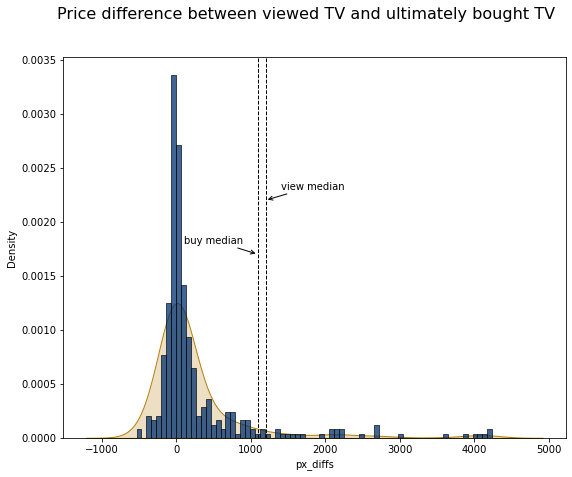

In [19]:
fig = plt.gcf()
fig.set_size_inches(9,7)
ax = sns.histplot(ub_pxdiffs['px_diffs'], stat='density', label='price diff',kde=False)
ax = sns.kdeplot(ub_pxdiffs['px_diffs'], color='#b58110', linewidth=1,fill=True)

#plot viewed TV median price as vertical line
plt.axvline(x=ub_pxdiffs.orig_px.median(),c='black',ls='--',linewidth=1)
ax.annotate('view median', xy=(1200,0.0022), xytext=(1400,0.0023),
            arrowprops=dict(arrowstyle='->', facecolor='#ffe945'),)
plt.axvline(x=ub_pxdiffs.ub_px.median(),c='black',ls='--',linewidth=1)
ax.annotate('buy median', xy=(1090,0.0017), xytext=(100,0.0018),
            arrowprops=dict(arrowstyle='->', facecolor='#ffe945'),)
fig.suptitle('Price difference between viewed TV and ultimately bought TV', size=16)

#save file for Presentation
fig.savefig('temp.png', transparent=True)

### What about segmenting the market to Premium (>\$2000) and Budget (not premium) TVs?

Why 2000? Some articles placed the cutoff at \$2500, but the brands straddling Premium and Budget in my dataset have mean prices that are lower 

In [20]:
[ub_pxdiffs[ub_pxdiffs.premium==True].orig_px.mean(),ub_pxdiffs[ub_pxdiffs.premium==True].ub_px.mean()]

[3582.4642268041184, 2587.4131325478616]

### Same plot, with annotation for premium and non-premium TVs

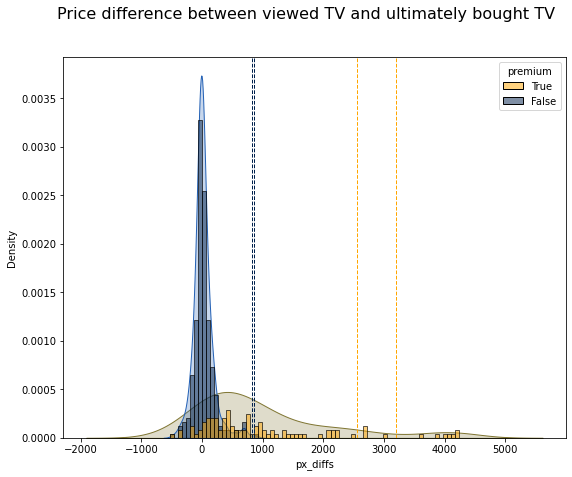

In [21]:
fig = plt.gcf()
fig.set_size_inches(9,7)
ax = sns.histplot(data = ub_pxdiffs, x='px_diffs', hue='premium', stat='density',
                  label='price diff', kde=False, hue_order=[True,False], palette=['#ffa600','#00204c'])
ax = sns.kdeplot(ub_pxdiffs[ub_pxdiffs.premium==True]['px_diffs'], color='#807633', linewidth=1,fill=True)
ax = sns.kdeplot(ub_pxdiffs[ub_pxdiffs.premium==False]['px_diffs'], color='#2461b5', linewidth=1,fill=True)


# plot PREMIUM TV median prices as vertical line
plt.axvline(x=ub_pxdiffs[ub_pxdiffs.premium==True].orig_px.median(),c='#ffa600',ls='--',linewidth=1)
plt.axvline(x=ub_pxdiffs[ub_pxdiffs.premium==True].ub_px.median(),c='#ffa600',ls='--',linewidth=1)

# plot NON-PREMIUM TV median prices as vertical line
plt.axvline(x=ub_pxdiffs[ub_pxdiffs.premium==False].orig_px.median(),c='#00204c',ls='--',linewidth=1)
plt.axvline(x=ub_pxdiffs[ub_pxdiffs.premium==False].ub_px.median(),c='#00204c',ls='--',linewidth=1)

fig.suptitle('Price difference between viewed TV and ultimately bought TV', size=16)

#save file for Presentation
fig.savefig('temp.png', transparent=True)

#### Fairly price sticky, but right skewed with a few opting for more expensive choice

# Check "brand loyalty": i.e. whether ultimately bought TV brand is same as viewed

In [22]:
ub_branddiffs = ub_final.drop(columns=['orig_px','ub_px'])

In [23]:
# Column 'loyal' = TRUE if original TV == ultimately bought TV
ub_branddiffs['loyal'] = ub_branddiffs.orig_brand == ub_branddiffs.ub_brand

In [24]:
# groupby originating TV, and count # of TRUE
ub_branddiffs = ub_branddiffs[ub_branddiffs['loyal']].groupby('sku').count()['loyal'].to_frame()
ub_branddiffs.describe()

,loyal
count,378.000000
mean,5.812169
std,2.120798
min,1.000000
25%,4.000000
50%,6.000000
75%,7.000000
max,10.000000


#### Merge back to main DF, keep only product brand and count of ultimately bought that are of same brand

In [25]:
ub_brandloyal = ub_final.merge(ub_branddiffs,how='inner',on='sku').drop(columns=['ub_sku','orig_px','ub_brand','ub_px'])
ub_brandloyal = ub_brandloyal.groupby('sku').last()

In [26]:
ub_brandloyal

,orig_brand,loyal
sku,,
5900939,Others,2
5900969,Others,4
6202766,Others,1
6280538,TCL,4
6302321,TCL,4
...,...,...
6479660,Others,3
6479707,Others,2
6479709,Others,3


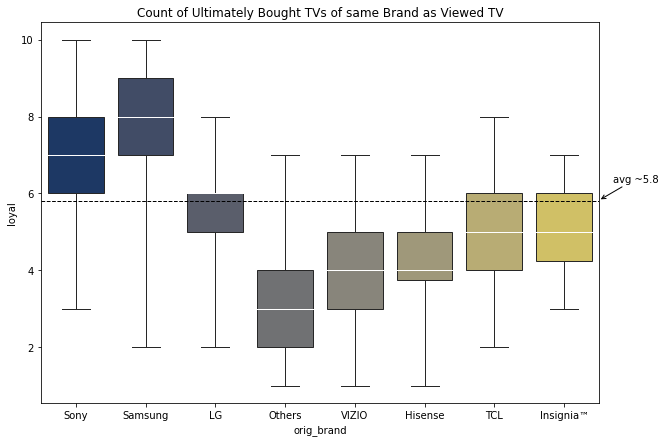

In [29]:
fig = plt.gcf()
fig.set_size_inches(10,7)

# set order of x-axis categories
order = ['Sony', 'Samsung', 'LG', 'Others', 'VIZIO', 'Hisense', 'TCL', 'Insignia™']

# change median line to white
PROPS = {'medianprops':{'color':'white'}}

# Plot scatter over boxplot
sns.boxplot(data = ub_brandloyal, x='orig_brand', y='loyal',
                order=order, palette='cividis', linewidth=1, whis=np.inf, **PROPS)\
                .set_title('Count of Ultimately Bought TVs of same Brand as Viewed TV')
# ax = sns.stripplot(data = ub_brandloyal, x='orig_brand', y='loyal',
#                    order=order, size=10, jitter=0.2,
#                    palette='cividis', linewidth=0.5, edgecolor='w', alpha=0.8)
plt.axhline(y=ub_brandloyal.loyal.mean(),c='black',ls='--',linewidth=1)
plt.annotate('avg ~5.8', xy=(7.5,5.82), 
            xytext=(7.7, 6.3), 
            arrowprops=dict(arrowstyle='->', facecolor='#ffe945'),)

#save file for Presentation
fig.savefig('temp.png', transparent=True)

In [28]:
ub_brandloyal.loyal.median()

6.0

# What about Reviews ⭐⭐⭐⭐?
### (as a proxy for sales)

In [28]:
# Load in cleaned and categorized data
bby = pd.read_csv('python_proj\\bby.csv')
bby = bby.set_index('sku')

### Remove price, review score, & review count outliers

In [29]:
bby2 = rem_outlier(bby,['regular_px','review_average','review_count'], 3)

In [30]:
# 35 outliers removed
bby2.shape[0] - bby.shape[0]

-46

In [31]:
# Create separate DF for calculation of correlations
bb_corr = bby2[['review_count','regular_px','screen_size','res_pixels','display_type','bezel','weight_nostand',
               'smart_capable','warranty_yrs','energy_KWh','refresh_Hz']]
bb_corr.columns = ['REVc','PRICE','SIZE','RES','DISP','BEZ','WGT','SMRT','WARR','ENRG','RFSH']

In [32]:
bb_corr.corr()

,REVc,PRICE,SIZE,RES,DISP,BEZ,WGT,SMRT,WARR,ENRG,RFSH
REVc,1.000000,-0.280578,-0.228250,-0.231324,-0.070409,-0.084776,-0.255621,-0.062331,-0.081896,-0.209406,-0.147263
PRICE,-0.280578,1.000000,0.623277,0.545966,0.411625,0.223428,0.723309,0.018918,0.052162,0.559382,0.648802
SIZE,-0.228250,0.623277,1.000000,0.493455,0.151979,0.438749,0.921312,0.232941,-0.037044,0.646038,0.375817
RES,-0.231324,0.545966,0.493455,1.000000,0.183656,0.302422,0.450392,0.182655,0.005748,0.614920,0.358455
DISP,-0.070409,0.411625,0.151979,0.183656,1.000000,0.237237,0.129352,0.161867,-0.082270,0.104108,0.438213
BEZ,-0.084776,0.223428,0.438749,0.302422,0.237237,1.000000,0.274191,0.308573,-0.105047,0.295538,0.278623
WGT,-0.255621,0.723309,0.921312,0.450392,0.129352,0.274191,1.000000,0.126187,-0.009893,0.618804,0.445618
SMRT,-0.062331,0.018918,0.232941,0.182655,0.161867,0.308573,0.126187,1.000000,-0.448286,0.105988,0.206227
WARR,-0.081896,0.052162,-0.037044,0.005748,-0.082270,-0.105047,-0.009893,-0.448286,1.000000,-0.034255,-0.076156
ENRG,-0.209406,0.559382,0.646038,0.614920,0.104108,0.295538,0.618804,0.105988,-0.034255,1.000000,0.396580


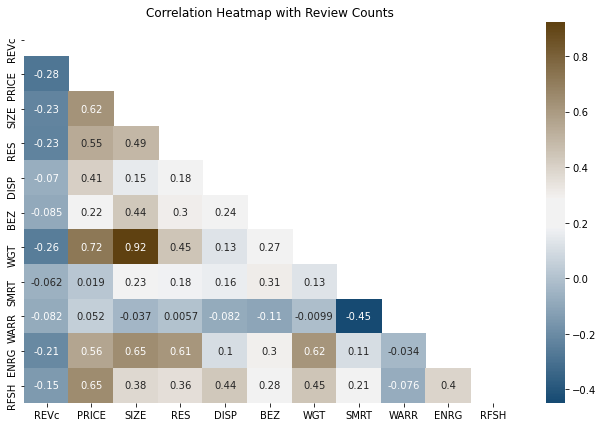

In [36]:
fig, ax = plt.subplots(figsize=(11, 7))

# Hide upper redundant heatmap
hide = np.triu(np.ones_like(bb_corr.corr(), dtype=bool))

# Configure a custom diverging colormap
n_plots = 10
cmap = sns.diverging_palette(245,50, s=90, l=30, sep=20, n=n_plots, as_cmap=True)

# Draw the heatmap
sns.heatmap(bb_corr.corr(), annot=True, mask = hide, cmap=cmap).set_title('Correlation Heatmap with Review Counts')

#save file for Presentation
fig.savefig('temp.png', transparent=True)

### Scatterplots

Text(0.5, 0.98, 'Price vs Review Score (by Size Class)')

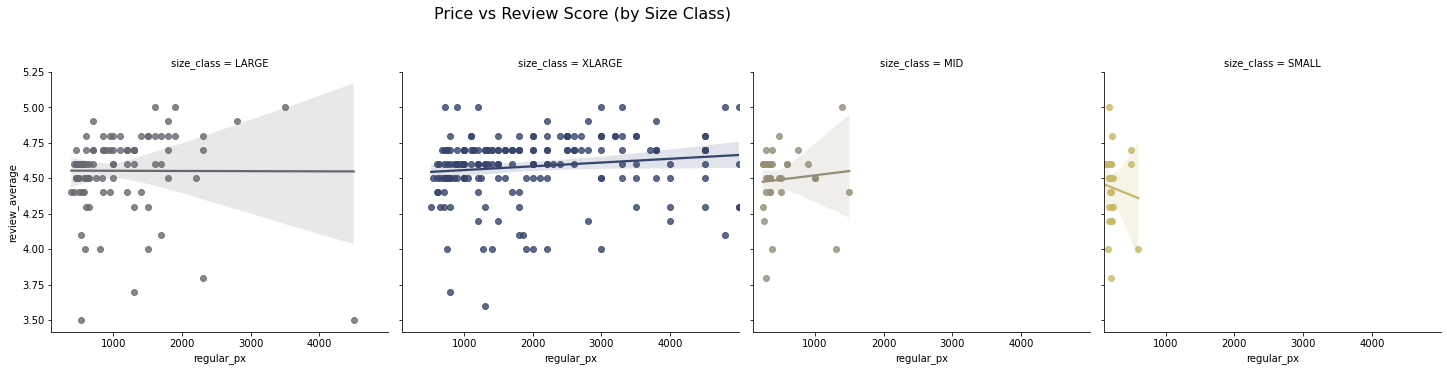

In [46]:
# Review scores and Price
hue_order = bby.groupby('size_class').median()['screen_size'].sort_values(ascending=False).index

fig = sns.lmplot(data = bby2,
           x='regular_px', 
           y='review_average',
           col='size_class',
           hue='size_class', hue_order=hue_order,
           palette='cividis')
fig.fig.subplots_adjust(top=0.8)
fig.fig.suptitle('Price vs Review Score (by Size Class)', ha='right', fontsize =16)

Text(0.5, 0.98, 'Price vs Review Count (by Size Class)')

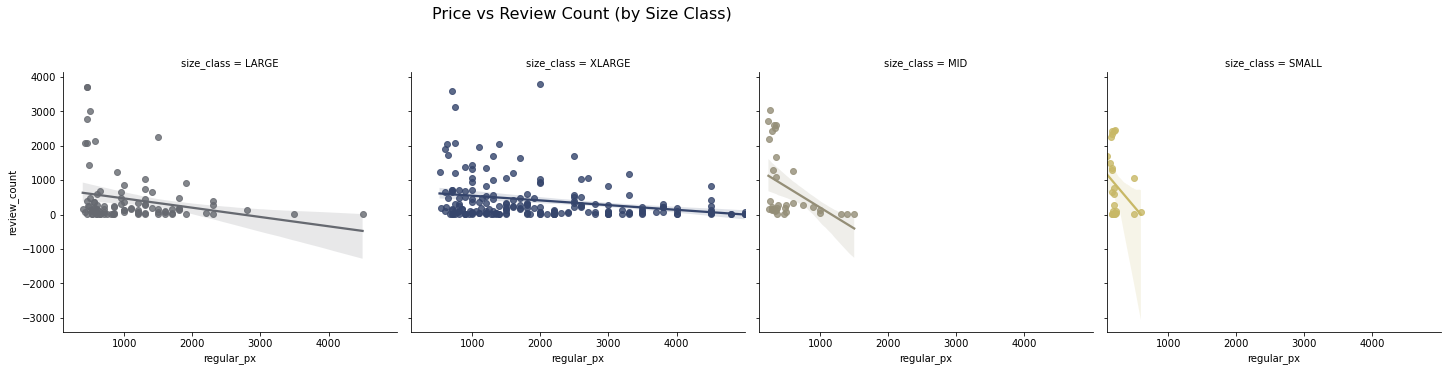

In [48]:
# Review counts and Price
hue_order = bby.groupby('size_class').median()['screen_size'].sort_values(ascending=False).index

fig = sns.lmplot(data = bby2,
           x='regular_px',
           y='review_count',
           col='size_class',
           hue='size_class', hue_order=hue_order,
           palette='cividis')
fig.fig.subplots_adjust(top=0.8)
fig.fig.suptitle('Price vs Review Count (by Size Class)', ha='right', fontsize =16)

### Since we know consumers are fairly price sensitive, it makes sense to segment the market by TV Price
TVs can be split btwn **regular** and **premium** ( >= \$2000)

In [50]:
bby2['premium'] = bby2['regular_px']>=2000

In [51]:
print(f'{bby2.premium.sum()} TVs fall into the Premium category')
print(f'- or {round(bby2.premium.sum()/bby2.shape[0]*100,1)}%')

80 TVs fall into the Premium category
- or 23.3%


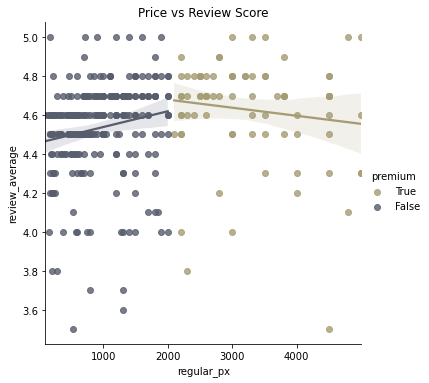

In [85]:
# Review scores and Price

fig = sns.lmplot(data = bby2,
           x='regular_px', 
           y='review_average',
           #col='premium',
           hue='premium', hue_order=[True,False],
           palette='cividis_r')
plt.title('Price vs Review Score')

#save file for Presentation
fig.savefig('temp.png', transparent=True)

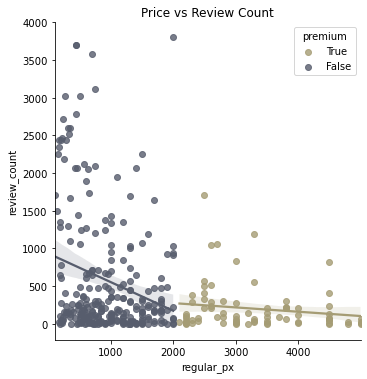

In [86]:
# Review counts and Price

fig = sns.lmplot(data = bby2,
                 x='regular_px',
                 y='review_count',
                 #col='premium',
                 hue='premium', hue_order=[True,False],
                 palette='cividis_r',
                 legend_out=False)
plt.title('Price vs Review Count')

#save file for Presentation
fig.savefig('temp.png', transparent=True)